# Compare two MSAs

In [1]:
include("../functions_seq_based_metrics.jl")

count_mismatch (generic function with 1 method)

In [2]:
using DelimitedFiles, Plots

In [3]:
using Revise, Pkg
Pkg.activate("/home/louise/MSA/BpAlignGpu.jl")
using BpAlignGpu

  Activating project at `~/MSA/BpAlignGpu.jl`


In [4]:
using CUDA
CUDA.device!(1)

┌ Warning: The NVIDIA driver on this system only supports up to CUDA 11.0.0.
│ For performance reasons, it is recommended to upgrade to a driver that supports CUDA 11.2 or higher.
└ @ CUDA /home/louise/.julia/packages/CUDA/Uurn4/src/initialization.jl:70


CuDevice(1): TITAN RTX

In [5]:
T = Float32
q = 21
ctype=Symbol("amino")
typel=Symbol("bm")
muext = 0.00
muint = 2.50;

In [6]:
fam = "PF00397"

path = "/home/louise/MSA/Data/test/PF00397/"
open(path)
L = 31; 

param_file = path * "Parameters_plm_PF00397.dat"
J, H = BpAlignGpu.read_parameters(param_file, q, L, gap=0, typel=typel);

delta = 5;
file_full = path * "PF00397_full_length_sequences.fasta"
file_hmmer = path * "PF00397_full.fasta"
file_hmmer_ins = path * "PF00397_full.inse"
al = BpAlignGpu.enveloptoalign( file_full, file_hmmer, file_hmmer_ins, delta = delta, ctype = ctype);
M = length(al)

using DelimitedFiles
lambda_file = path * "Lambda_PF00397.dat"
Lambda_all = readdlm(lambda_file)
lambda_o = Lambda_all[1,:];
lambda_e = Lambda_all[2,:];

┌ Info: Assuming J i j a b and h i a format
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:37
┌ Info: Output tersors: J[a b i j] and h[a i]
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:39
┌ Info: Gap in input file 0 now in 21
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:40


In [7]:
#fam = "PF00684"
#open("/home/louise/MSA/Data/test/PF00684/")
#L = 67; 

#J, H = BpAlignGpu.read_parameters("/home/louise/MSA/Data/test/PF00684/Parameters_bm_PF00684seed_potts.dat", q, L, gap=0, typel=typel);

#delta = 50;
#al = BpAlignGpu.enveloptoalign( "/home/louise/MSA/Data/test/PF00684/Test_PF00684.full", "/home/louise/MSA/Data/test/PF00684/Test_PF00684.fasta", "/home/louise/MSA/Data/test/PF00684/Test_PF00684.ins", delta = delta, ctype = ctype);
#M = length(al)

#Lambda_all = readdlm("/home/louise/MSA/Data/test/PF00684/Lambda_PF00684.dat")
#lambda_o = Lambda_all[:,1];
#lambda_e = Lambda_all[:,2];


In [8]:
function extract_data(namefile::String)
    data = readdlm(namefile);
    param = data[1,:] #param = data[1,1:np]
    nsamp =param[1]

    inds = data[2,1:nsamp];
    res = data[3:end,:];

    xnsols = fill((0,0), L, nsamp)
    for ns in 1:nsamp
        for i=1:L
            x = res[ns,i]
            n = res[ns,L+i]
            xnsols[i,ns] = (x,n)
        end
    end

    sats = []
    ens = []
    seqpas = []
    for (i, idx0) in pairs(inds)
    #    @show i, idx0
        seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
        N = length(al[idx0][2])
        pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)

        c = BpAlignGpu.check_sr!(xnsols[:,i], L, N)

        seqsol = BpAlignGpu.convert_soltosequence!(xnsols[:,i], seq.strseq, N, L)
        energy = BpAlignGpu.compute_potts_en(pm.J, pm.H, seqsol[1], pm.L, seq.ctype)
#        energy = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol[2], pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)
        append!(sats, sum(c))
        append!(ens, energy)
        append!(seqpas, [seqsol[1]])
    end
    return param, inds, sats, ens, xnsols, seqpas
end


extract_data (generic function with 1 method)

## Loads MSAs

In [9]:
namefile = "run_GS_seedPF00397_sce_viterbi.txt"
param1, inds1, sats1, ens1, xnsols1, seqpas1 = extract_data(namefile);

In [10]:
seqpas1

374-element Vector{Any}:
 "LPEHWKACRSEK-GELYYFNFKTGESIWDHP"
 "RREDWEARIDSH-GRVFYVDHVNRTTTWQRP"
 "LPPGWVEKVSNSTGKTYYLNQHTKASQWERP"
 "LPEGWLAQWDGRQQRWYYVQPVTRKSQWEIP"
 "LFPGWDKKVDQN-GRLYFIDHNTRTTTFIDP"
 "CTHSWAVSQSPE-GYYYYYNSQTQASQWEVP"
 "LPAGWEERATLE-GSVYYADHGSQRTQWTHP"
 "SECDWSEHTCPN-GNKYYFHCITCESTWEKP"
 "DYQKWIESFTED-GYPFYYNTNTGESSWYKP"
 "LPDGWHAVIEVQTNDVYFWNIHTDETQWKVP"
 "LPLGWEAAKDRATGKTYYFNRTTSQRQWEPP"
 "LAEGWFPVIDEASGDTYYANELTGETSWDKP"
 "LPAGWEERHTQA-GRVYYVNHVTKTTQWNAP"
 ⋮
 "KVGAWQAVKDAE-GKTYYWNKDTGATTWDPP"
 "LPPGWEERTTKD-GWVYYANHTEEKTQWEHP"
 "RLDAWTAHKSEA-GVLYYYNSVTGQSTYEKP"
 "SQCSWTAQLSPE-GYTYYYNWTTGESKWEKP"
 "LPYPWVARWDDRDQRWFYVNEQTGERSWERP"
 "LPVGWEAKVSRSTGRVYYVNRKLGKSQFERP"
 "LPDGWVAQWDEEYQQYFYVNKRTGKSQWDVP"
 "LPPGWYSVLDPASGDEYYVND-SGETTWDKP"
 "PPPPWKAIVDAKSGRTYYWDASSGETTWTMP"
 "LSYGWERAIDSK-GRSYYINHLNKTTTYEAP"
 "LPDGWEARATSD-GRAYYVNHNTKTTSWDDP"
 "LPYGWSEAIAAD-GQKYYMNHITQKTSWERP"

## hmmer

In [11]:
ens_hmmer = []
seqpas_hmmer = []
for (i, idx0) in pairs(inds1)
    seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
    N = length(al[idx0][2])
    pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)
    
#    seqsol = al[idx0][4]
#    energy = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol, pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)
    seqsol = al[idx0][3]
    energy = BpAlignGpu.compute_potts_en(pm.J, pm.H, seqsol, pm.L, seq.ctype)
    append!(ens_hmmer, energy)
    append!(seqpas_hmmer, [al[idx0][3]])
end

In [12]:
seqpas_hmmer

374-element Vector{Any}:
 "LPEHWKACRSEK-GELYYFNFKTGESIWDHP"
 "--EDWEARIDSH-GRVFYVDHVNRTTTWQRP"
 "LPPGWVEKVSNSTGKTYYLNQHTKASQWERP"
 "LPEGWLAQWDGRQQRWYYVQPVTRKSQWEIP"
 "LFPGWDKKVDQN-GRLYFIDHNTRTTTFIDP"
 "---SWAVSQSPE-GYYYYYNSQTQASQWEVP"
 "LPAGWEERATLE-GSVYYADHGSQRTQWTHP"
 "--CDWSEHTCPN-GNKYYFHCITCESTWEKP"
 "----WIESFTED-GYPFYYNTNTGESSWYKP"
 "LPDGWHAVIEVQTNDVYFWNIHTDETQWKVP"
 "LPLGWEAAKDRATGKTYYFNRTTSQRQWEPP"
 "LAEGWFPVIDEASGDTYYANELTGETSWDKP"
 "LPAGWEERHTQA-GRVYYVNHVTKTTQWNAP"
 ⋮
 "---AWQAVKDAE-GKTYYWNKDTGATTWDPP"
 "LPPGWEERTTKD-GWVYYANHTEEKTQWEHP"
 "---AWTAHKSEA-GVLYYYNSVTGQSTYEKP"
 "---SWTAQLSPE-GYTYYYNWTTGESKWEKP"
 "LPYPWVARWDDRDQRWFYVNEQTGERSWERP"
 "LPVGWEAKVSRSTGRVYYVNRKLGKSQFERP"
 "LPDGWVAQWDEEYQQYFYVNKRTGKSQWDVP"
 "LPPGWYSVLDPASGDEYYVNDS-GETTWDKP"
 "-PPPWKAIVDAKSGRTYYWDASSGETTWTMP"
 "-SYGWERAIDSK-GRSYYINHLNKTTTYEAP"
 "LPDGWEARATSD-GRAYYVNHNTKTTSWDDP"
 "LPYGWSEAIAAD-GQKYYMNHITQKTSWERP"

## seed

In [13]:
seedfile = readdlm("seedPF00397_index_name_alignment.txt");

In [14]:
Int64.(seedfile[:,1]) == inds1

true

In [15]:
seqpas_seed = String.(seedfile[:,3]);

In [16]:
typeof(seqpas_seed[1])

String

# scatter plot of energies

In [17]:
diffE = ens_hmmer .- ens1;

In [18]:
findall(diffE .< 0)

2-element Vector{Int64}:
 150
 208

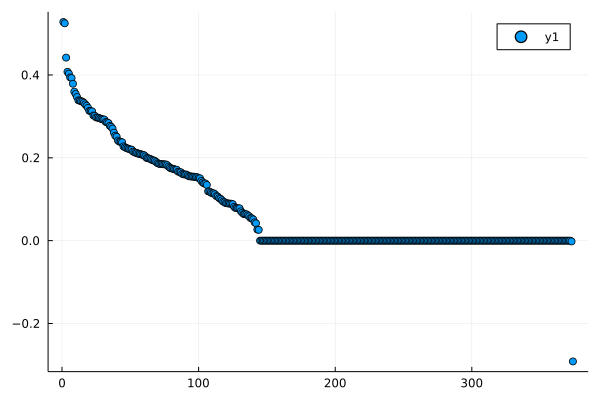

In [19]:
scatter(sort(diffE./L,rev=true))

# Hamming distance

In [32]:
MSA1 = seqpas_seed
MSA2 = seqpas_hmmer;
namefile = "data_compareMSA_PF00397_seedVS_hmmer.txt"


"data_compareMSA_PF00397_seedVS_hmmer.txt"

In [33]:
typeof(MSA1[1])

String

In [34]:
typeof(MSA2[1])

String

In [35]:
Hdist = []
for i in eachindex(inds1)
    dist = hamming_distance(MSA1[i], MSA2[i])
    #if dist > 0
    #    @show i, dist
    #end
    append!(Hdist, dist)
end

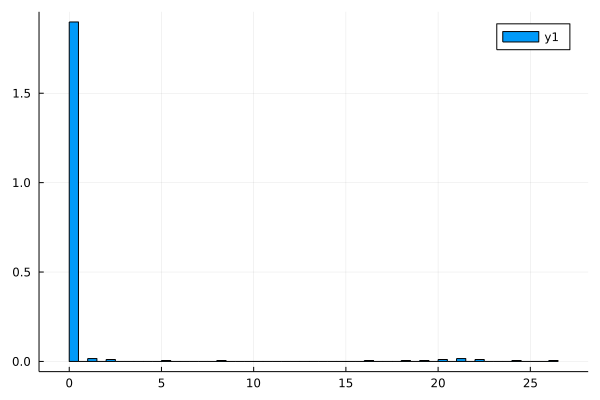

In [36]:
histogram(Hdist, bins = 100, normed = true)

In [25]:
open(namefile, "a") do io
    writedlm(io, [Hdist])
end    


# GAP +/-

In [26]:
Gp = []
Gm = []
for i in eachindex(inds1)
    np, nm = count_gap_pm(MSA1[i], MSA2[i])
    append!(Gp, np)
    append!(Gm, nm)
end

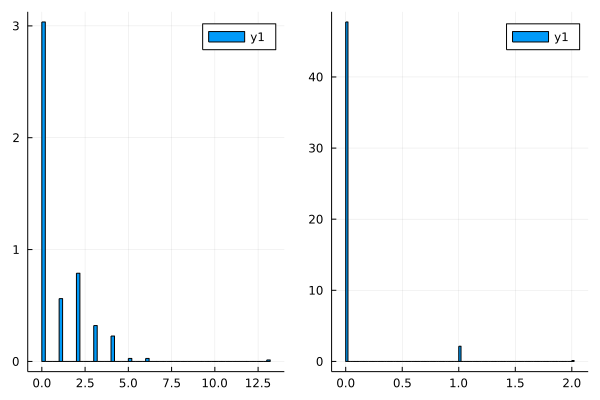

In [27]:
plot(histogram(Gp, bins = 100, normed = true), histogram(Gm, bins = 100, normed = true))

In [28]:
open(namefile, "a") do io
    writedlm(io, [Gp])
    writedlm(io, [Gm])
end    


# Mismatch

In [29]:
Mism = []
for i in eachindex(inds1)
    m = count_mismatch(MSA1[i], MSA2[i])
    append!(Mism, m)
end

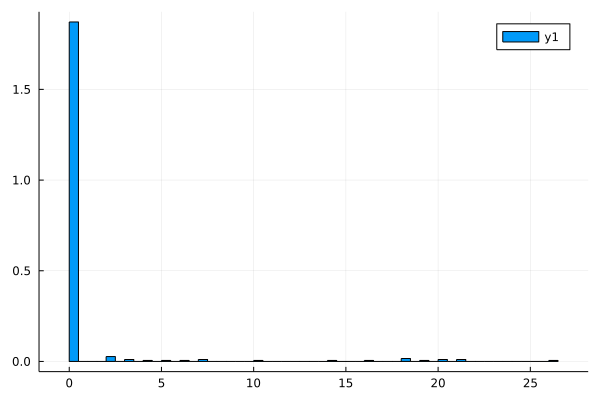

In [30]:
histogram(Mism, bins = 50, normed = true)

In [31]:
open(namefile, "a") do io
    writedlm(io, [Mism])
end    


# Proximity

In [54]:
MSA1 = seqpas_hmmer

100-element Vector{Any}:
 "CGVCKGSGARGAKAKQCAKCEGNGYITVNSARGGGVIGVSKAMCTDCSGEGEKLREKDRCKKCKGNK"
 "CPECHGSGAEKGFPVTCPTCQGKGRVARATQSFGTFM--TSSTCPTCKAEGSVI--EKKCSTCTGKG"
 "CERCDGKGNEPGTVQHCHYCSGSGMETIN---TGPFV--MRSTCRRCGGRGSII--TNPCVVCRGAG"
 "CATCGGSGAKPGTPITCRKCGGRGTIQVERRTLGNMM--TEQECDVCHGSGKEI--EEKCETCHGSG"
 "CTVCHGSGSEAGGRKVCATCQGSGQVRRSS---GFF--SIASPCPSCSGEGYMI--DKPCRACGGSG"
 "CAACKGSGVKPGTPVSCVTCGGLGAV--EQMGLGGMF-RMRTTCPACKGAGKIY--KEKCADCRGAG"
 "CQSCNGSGARKGSPKNCETCNGIGQVRIQQ---GFF--SIQQTCPHCHGEGKVI--TDPCTACHGQG"
 "CETCNGTGAKPGTPSSCGTCGGSGQVRRATRTFGSFT--QVSVCPTCNGSGQVI--EEKCGTCAGKG"
 "CDTCSGSGAKPGTPETCKHCQGTGQMNIEQNTFGRVV--NKRVCHHCSGTGKEI--KEKCTTCSGKG"
 "CSKCDGTGSQDKKTQTCHVCHGSGRVRIKRQ-LAPMIQQQDIPCQQCGGKGSVV--KHKCTTCQGN-"
 "CKTCEGSGAAPGTPETCDTCGGAGRVRAQQ---GFFT--MERTCPRCNGKGKTI--KKPCKDCGGAG"
 "CDRCRGAGTAEGTVTTCDTCGGQGEIQSVQRSLGQVV--TARPCPVCRGFGEVI--TDPCQQCGGDG"
 "CEVCLGTGSKVGSMRICSTCGGRGQVMRTEQTFGLFS--QVSVCPNCGGDGEVI--SEYCRKCSGKG"
 ⋮
 "CQTCHGTGAKPGTPTTCTKCGGKGQIVYTSQSFGTV--RNVTTCPDC